# Exercício RAG

O objetivo do exercício desta semana é construir um sistema de RAG combinando busca e LLMs.

Dataset
Usaremos o DATASET IIRC. Você pode baixar o conjunto de testes e os documentos de contexto usando os comandos abaixo:  
wget https://iirc-dataset.s3.us-west-2.amazonaws.com/context_articles.tar.gz  
wget https://iirc-dataset.s3.us-west-2.amazonaws.com/iirc_test.json  
tar -xf context_articles.tar.gz  

- Etapa 1: Segmentação do texto - o método usado para segmentação (aka. chucking e janelamento) é livre. A sugestão é usar as ferramentas do langchain.
- Etapa 2: Computação das embeddings e indexação - A ideia é usar busca densa, usando um modelo de embeddings para criar representações vetoriais para os segmentos obtidos na etapa 1. Fiquem livres para usar qualquer modelo, mas sugerimos os modelos do sentence-transformers. Usem o FAISS para criar e gerenciar o índice. Usar langchain.
- Etapa 3: Geração das respostas (prompt) - Usar o gpt-5-nano (mais barato) ---- Não usar langchain (ou similares)
- Etapa 4: Avaliação  -  É talvez o ponto mais importante do trabalho. Sugerimos uma avaliação com a métrica F1-bag-of-words (ver slide 147).

Observações:
1. O IIRC tem perguntas com diferentes tipos de resposta: sem resposta, boleana, span e numérico. Uma sugestão é desconsiderar as perguntas sem resposta e focar apenas nas 150 primeiras com resposta.
2. Se indexar todos os context_articles for muito custoso, sugere-se indexar apenas os artigos que estão com título listado no campo "link" de cada pergunta do conjunto de teste. Ver código do Visconde para entender como fazer.
3. O código do Visconde pode não ser tão fácil de entender. Falar com Jayr para tirar dúvidas.
4. Usem o slack.

In [ ]:
import os
import sys
import faiss
import time
import logging
import numpy as np
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import FAISS as LangchainFAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from typing import List, Dict

# Remove all handlers associated with the root logger object (for notebook re-runs)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.WARNING, format="%(message)s", stream=sys.stdout)

/Users/mabosco/Desktop/mestrado/IA368HH/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carrango arquivos

In [ ]:
#os.getcwd()
#os.chdir('08. Aula 7_8 - RAG')
#print("Diretório atual:", os.getcwd())

Diretório atual: /Users/mabosco/Desktop/mestrado/IA368HH/08. Aula 7_8 - RAG


In [ ]:
import json
iirc_test = json.load(open('data/iirc_test.json','r'))
context_articles = json.load(open("data/context_articles.json",'r'))

# Tramento dados

In [ ]:
from bs4 import BeautifulSoup

def parse_html(text: str) -> str:
    soup = BeautifulSoup(text, "html.parser")
    parsed = soup.get_text(separator=" ", strip=True)
    return parsed

relevant_titles = set()

# Coleta titulos das perguntas principais
for item in iirc_test:
    relevant_titles.add(item['title'].lower())

# Adicionar títulos dos links mencionados nas perguntas
for item in iirc_test:
    for link in item["links"]:
        if link['target'].lower() in context_articles:
            relevant_titles.add(link['target'].lower())

print(f"Total of relevant articles to index: {len(relevant_titles)}")

documents = []
all_titles = []

for item in iirc_test:
    if item['title'].lower() not in all_titles:
        documents.append({
                "title": item['title'],
                "content": parse_html(item["text"])
            })
        all_titles.append(item['title'].lower())

    # Processar apenas links que estão nos títulos relevantes
    for link in item["links"]:
        if (link['target'].lower() in relevant_titles and
            link['target'].lower() not in all_titles):
            documents.append({
                "title": link['target'],
                "content": parse_html(context_articles[link['target'].lower()])
            })
            all_titles.append(link['target'].lower())

print(f"Total of documents processed: {len(documents)}")
print(f"Estimated reduction: {len(context_articles) - len(relevant_titles)} unindexed articles")

Total of relevant articles to index: 7028
Total of documents processed: 7028
Estimated reduction: 49522 unindexed articles


In [ ]:
documents[0]

{'title': 'Palici',
 'content': "The Palici (Παλικοί in Greek), or Palaci, were a pair of indigenous Sicilian chthonic deities in Roman mythology, and to a lesser extent in Greek mythology. They are mentioned in Ovid's Metamorphoses V, 406, and in Virgil's Aeneid IX, 585. Their cult centered on three small lakes that emitted sulphurous vapors in the Palagonia plain, and as a result these twin brothers were associated with geysers and the underworld. There was also a shrine to the Palaci in Palacia, where people could subject themselves or others to tests of reliability through divine judgement; passing meant that an oath could be trusted. The mythological lineage of the Palici is uncertain; one legend made the Palici the sons of Zeus, or possibly Hephaestus, by Aetna or Thalia, but another claimed that the Palici were the sons of the Sicilian deity Adranus."}

In [ ]:
relevant_titles

{'incense for the damned',
 'battle of hebron',
 'frederic whitcombe',
 'william cochran (physicist)',
 'the four horsemen (professional wrestling)',
 'aline barnsdall',
 'penalty kick (association football)',
 'european senior chess championship',
 'hyères',
 'bronx zoo',
 'list of james bond villains',
 '1936–1939 arab revolt in palestine',
 'bill elliott racing',
 'beta oxidation',
 'the fame ball tour',
 'aartswoud',
 'dixon hall lewis',
 'siege of yorktown (1862)',
 'buzzword',
 'pavel svinyin',
 'bad hersfelder festspiele',
 'sharleen spiteri',
 'gresley f.c.',
 'morgan fisher',
 'houston rockets',
 'tomb raider: underworld',
 'trinity college dublin',
 'north island',
 'national cartoonists society',
 'norman foster, baron foster of thames bank',
 'li mi (republic of china general)',
 "władysław sikorski's death controversy",
 'bruce lee',
 'jimmy t. murakami',
 'tonight with arnold clavio',
 'felt (band)',
 'defender (association football)',
 'swedish navy',
 'william hickton (

In [ ]:
from tqdm import tqdm
import spacy

nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

stride = 2
max_length = 3

# Cria janelamento de documentos (Extraido do Visconde)
def window(documents, stride=2, max_length=3):
    treated_documents = []
    total_sentences = 0
    sentence_lengths = []

    for j,document in enumerate(tqdm(documents)):
        doc_text = parse_html(document['content'])
        doc = nlp(doc_text[:10000]) # Pega somente os primeiros 10000 caracteres - evita kernel crash
        sentences = [sent.text.strip() for sent in doc.sents]

        # Coletar estatísticas das sentenças
        total_sentences += len(sentences) # Total de sentenças
        for sent in sentences:
            sentence_lengths.append(len(sent.split())) # Tamanho de cada sentença - em palavras

        for i in range(0, len(sentences), stride):
            segment = ' '.join(sentences[i:i + max_length])
            treated_documents.append({
                "id": f"doc{j}_seg{i}",
                "title": document['title'],
                "contents": document['title']+". "+segment,
                "segment": segment
            })
            if i + max_length >= len(sentences):
                break

    # Calcular e exibir estatísticas
    if sentence_lengths:
        avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths)
        print(f"Total processed sentences: {total_sentences}")
        print(f"Average sentence len: {avg_sentence_length:.2f} words")
        print(f"Min sentence size: {min(sentence_lengths)} words")
        print(f"Max sentence size: {max(sentence_lengths)} words")
        print(f"Total treated documents (i.e. segments): {len(treated_documents)}")

    return treated_documents

treated_documents = window(documents)

100%|██████████| 7028/7028 [00:21<00:00, 329.82it/s]


Total processed sentences: 371112
Average sentence len: 21.86 words
Min sentence size: 0 words
Max sentence size: 902 words
Total treated documents (i.e. segments): 183841


In [ ]:
def prepare_test_data(test_set, max_questions=150):
    questions_with_answers = []

    # Dependendo do tipo de resposta, pegamos campos corretos
    extractors = {
        'span': lambda ans: ans['answer_spans'][0]['text'] if ans.get('answer_spans') else '',
        'value': lambda ans: str(ans.get('answer_value', '')),
        'binary': lambda ans: str(ans.get('answer_value', ''))
    }

    for item in test_set:
        if 'questions' not in item:
            continue
        for question_data in item['questions']:
            answer_data = question_data.get('answer', {})
            answer_type = answer_data.get('type')

            # Skip se não tem resposta
            if not answer_type or answer_type == 'none':
                continue

            if answer_type in extractors:
                try:
                    answer_text = extractors[answer_type](answer_data).strip()
                    if answer_text:  # Only add if we got valid text
                        questions_with_answers.append({
                            'question': question_data['question'],
                            'answer': answer_text,
                            'answer_type': answer_type,
                            'id': len(questions_with_answers)
                        })

                        if len(questions_with_answers) >= max_questions:
                            return questions_with_answers
                except (KeyError, IndexError, TypeError):
                    # Skip respostas malformadas
                    continue

    return questions_with_answers

test_questions = prepare_test_data(test_set=iirc_test, max_questions=150)
print(f"Amount test questions: {len(test_questions)}")

from collections import Counter
answer_types = Counter([q['answer_type'] for q in test_questions])
print(f"Distribution by answer type: {dict(answer_types)}")

print("\nExamples of questions:")
for i in range(min(3, len(test_questions))):
    q = test_questions[i]
    print(f"\nQuestion {i+1}: {q['question']}")
    print(f"Expected answer: {q['answer']}")
    print(f"Type: {q['answer_type']}")

Amount test questions: 150
Distribution by answer type: {'span': 98, 'value': 42, 'binary': 10}

Examples of questions:

Question 1: What is Zeus know for in Greek mythology?
Expected answer: sky and thunder god
Type: span

Question 2: How long had the First World War been over when Messe was named aide-de-camp?
Expected answer: 5
Type: value

Question 3: How old was Messe when the First World War started?
Expected answer: 30
Type: value


In [ ]:
test_questions

[{'question': 'What is Zeus know for in Greek mythology?',
  'answer': 'sky and thunder god',
  'answer_type': 'span',
  'id': 0},
 {'question': 'How long had the First World War been over when Messe was named aide-de-camp?',
  'answer': '5',
  'answer_type': 'value',
  'id': 1},
 {'question': 'How old was Messe when the First World War started?',
  'answer': '30',
  'answer_type': 'value',
  'id': 2},
 {'question': 'How long had Angela Scoular been acting professionally when she appeared in the movie "On Her Majesty\'s Secret Service"?',
  'answer': '2',
  'answer_type': 'value',
  'id': 3},
 {'question': 'What is the capacity of the stadium where Brunt returned to action after a torn ACL?',
  'answer': '26,688',
  'answer_type': 'span',
  'id': 4},
 {'question': 'Which stadium where Brunt played can hold more people, The Hawthorns or White Hart Lane?',
  'answer': 'White Hart Lane',
  'answer_type': 'span',
  'id': 5},
 {'question': 'In which country was Wilhelm Müller born?',
  'ans

# Computação de embeddings e indexação FAISS

In [ ]:
# Configurar modelo de embeddings
model_name = "all-MiniLM-L6-v2"
embeddings_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'mps'},
    encode_kwargs={'normalize_embeddings': True}
)

/var/folders/yq/_cz8lh1x52qd8k6yygm70pt5tx9lx2/T/ipykernel_58932/3670452472.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings_model = HuggingFaceEmbeddings(


In [ ]:
# Preparar documentos para indexação
def prepare_documents_for_indexing(treated_documents):
    documents = []

    for doc in treated_documents:
        if doc['segment'] != "":  # Só processa segmentos não vazios
            # Criar documento Langchain
            langchain_doc = Document(
                page_content=doc['contents'],  # Texto completo (título + segmento)
                metadata={
                    'id': doc['id'],
                    'title': doc['title'],
                    'segment': doc['segment']
                }
            )
            documents.append(langchain_doc)

    return documents

# Preparar documentos
docs_for_indexing = prepare_documents_for_indexing(treated_documents)
print(f"Indexed documents: {len(docs_for_indexing)}")

# Mostrar exemplo de documento
if docs_for_indexing:
    print("\nDocument Example:")
    print(f"Content: {docs_for_indexing[0].page_content[:200]}...")
    print(f"Metadata: {docs_for_indexing[0].metadata}")

Indexed documents: 183841

Document Example:
Content: Palici. The Palici (Παλικοί in Greek), or Palaci, were a pair of indigenous Sicilian chthonic deities in Roman mythology, and to a lesser extent in Greek mythology. They are mentioned in Ovid's Metamo...
Metadata: {'id': 'doc0_seg0', 'title': 'Palici', 'segment': "The Palici (Παλικοί in Greek), or Palaci, were a pair of indigenous Sicilian chthonic deities in Roman mythology, and to a lesser extent in Greek mythology. They are mentioned in Ovid's Metamorphoses V, 406, and in Virgil's Aeneid IX, 585. Their cult centered on three small lakes that emitted sulphurous vapors in the Palagonia plain, and as a result these twin brothers were associated with geysers and the underworld."}


In [ ]:
# Criar o índice FAISS a partir dos documentos
vector_store = LangchainFAISS.from_documents(
    documents=docs_for_indexing,
    embedding=embeddings_model
)

print(f"Index size: {vector_store.index.ntotal}")

index_path = "data/iirc_indices"
os.makedirs(index_path, exist_ok=True)
vector_store.save_local(index_path)
print(f"Index saved to: {index_path}")

Index size: 183841
Index saved to: data/iirc_indices


In [ ]:
vector_store

# Busca top k contextos

In [ ]:
# Função de busca no índice
def buscar_contextos_relevantes(query, vector_store, k=5):
    """
    Busca os k chunks mais relevantes para a query
    """
    resultados = vector_store.similarity_search(query, k=k) # Busca por similaridade
    return resultados

# Testar a função de busca
query_teste = "What is the capital of France?"
print(f"Query de teste: {query_teste}")
print("=" * 50)

resultados = buscar_contextos_relevantes(query_teste, vector_store, k=3)

print("Exemplos de resultados - 3 contextos mais relevantes para a query:")
for resultado in resultados:
    print(f"Texto: {resultado.page_content[:200]}...")
    print(f"Metadata: {resultado.metadata}")
    print("-" * 80)

Query de teste: What is the capital of France?
Exemplos de resultados - 3 contextos mais relevantes para a query:
Texto: France. France (), officially the French Republic (, ), is a country whose territory consists of metropolitan France in Western Europe and several overseas regions and territories . The metropolitan a...
Metadata: {'id': 'doc1559_seg0', 'title': 'France', 'segment': 'France (), officially the French Republic (, ), is a country whose territory consists of metropolitan France in Western Europe and several overseas regions and territories . The metropolitan area of France extends from the Mediterranean Sea to the English Channel and the North Sea , and from the Rhine to the Atlantic Ocean. It is bordered by Belgium , Luxembourg and Germany to the northeast, Switzerland and Italy to the east, and Andorra and Spain to the south.'}
--------------------------------------------------------------------------------
Texto: Paris. Paris () is the capital and most populous city o

In [ ]:
test_questions[0]

{'question': 'What is Zeus know for in Greek mythology?',
 'answer': 'sky and thunder god',
 'answer_type': 'span',
 'id': 0}

In [ ]:
# Testar com uma pergunta real do dataset IIRC
pergunta_real = test_questions[0]
print("Pergunta real do dataset:")
print(f"Pergunta: {pergunta_real['question']}")
print(f"Resposta esperada: {pergunta_real['answer']}")
print("=" * 80)

# Buscar contextos relevantes
resultados_real = buscar_contextos_relevantes(pergunta_real['question'], vector_store, k=5)

print("Contextos mais relevantes encontrados:")
for resultado in resultados_real:
    print(f"Texto: {resultado.page_content[:200]}...")
    print(f"Metadata: {resultado.metadata}")
    print("-" * 80)

Pergunta real do dataset:
Pergunta: What is Zeus know for in Greek mythology?
Resposta esperada: sky and thunder god
Contextos mais relevantes encontrados:
Texto: Zeus. Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion , who rules as king of the gods of Mount Olympus . His name is cognate with the fir...
Metadata: {'id': 'doc9_seg0', 'title': 'Zeus', 'segment': 'Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion , who rules as king of the gods of Mount Olympus . His name is cognate with the first element of his Roman equivalent Jupiter . His mythologies and powers are similar, though not identical, to those of Indo-European deities such as Jupiter , Perkūnas , Perun , Indra and Thor .'}
--------------------------------------------------------------------------------
Texto: Zeus. Some also include Eileithyia , Eris , Enyo and Angelos as their daughters. In the section

# Geração de respostas

In [ ]:
# Configurar cliente OpenAI moderno
from openai import OpenAI
client = OpenAI(api_key="") # preencher com key quando for usar

In [ ]:
def gera_prompt(
        query: str,
        vector_store: LangchainFAISS,
        k: int = 5,
        answer_type: str = "span"
):
    """
    Gera o prompt para a pergunta e busca os contextos mais relevantes
    """
    # Buscar contextos relevantes
    resultados = buscar_contextos_relevantes(query, vector_store, k=k)

    # Aciona contexto ao prompt
    prompt = "Most relevant contexts:\n"
    for i, resultado in enumerate(resultados):
        prompt += f"Context {i+1}:\n"
        prompt += f"Text: {resultado.page_content}\n"

    prompt += "Question: " + query + "\n"  # Adiciona a pergunta ao prompt
    prompt += "Answer type: \n\n" + answer_type  # Adiciona tipo de pergunta ao prompt

    # Acionando instruções ao prompt
    #prompt += """Instructions:\n
    #- Answer the question based on the contexts provided.\n
    #- If the answer is not present in the context, you can answer with 'I don't know'.\n
    #- If answer type is 'binary', answer with 'yes' or 'no'.\n
    #- If answer type is 'value', answer with a number.\n
    #- For other answer types provide the shortest text response possible.\n

    prompt += "Your answer:"

    return prompt

In [ ]:
pergunta_real

{'question': 'What is Zeus know for in Greek mythology?',
 'answer': 'sky and thunder god',
 'answer_type': 'span',
 'id': 0}

In [ ]:
gera_prompt(pergunta_real['question'], vector_store, k=5, answer_type=pergunta_real['answer_type'])

'Most relevant contexts:\nContext 1:\nText: Zeus. Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion , who rules as king of the gods of Mount Olympus . His name is cognate with the first element of his Roman equivalent Jupiter . His mythologies and powers are similar, though not identical, to those of Indo-European deities such as Jupiter , Perkūnas , Perun , Indra and Thor .\nContext 2:\nText: Zeus. Some also include Eileithyia , Eris , Enyo and Angelos as their daughters. In the section of the Iliad known to scholars as the Deception of Zeus , the two of them are described as having begun their sexual relationship without their parents knowing about it. The conquests of Zeus among nymphs and the mythic mortal progenitors of Hellenic dynasties are famous.\nContext 3:\nText: Zeus. Since lightning is quite powerful and sometimes deadly, it is a bold sign when lightning strikes because it is known that Zeus most likely threw the

In [ ]:
def gera_resposta(
    pergunta: dict,
    vector_store: LangchainFAISS,
    k: int = 5
):
    """
    Gera a resposta para a pergunta
    """
    # Gera o prompt
    prompt = gera_prompt(pergunta['question'], vector_store, k=k, answer_type=pergunta['answer_type'])

    # Gera a resposta
    response = client.responses.create(
        model="gpt-5-nano",
        input=[
          {
            "role": "developer",
            "content": [
              {
                "type": "input_text",
                "text": "You are an answer extractor.\\n\nInstructions:\\n\n- Answer the question based on the contexts provided.\\n\n- If the answer is not present in the context, you can answer with 'I don't know'.\\n\n- If answer type is 'binary', answer with 'yes' or 'no'.\\n\n- If answer type is 'value', answer with a number.\\n\n- For other answer types provide the shortest text response possible.\\n"

              }
            ]
          },
          {
            "role": "user",
            "content": [
              {
                "type": "input_text",
                "text": prompt
              }
            ]
          }
        ],
        text={
          "format": {
            "type": "text"
          },
          "verbosity": "low"
        },
        reasoning={
          "effort": "minimal"
        },
        tools=[],
        store=True
    )

    return response.output[1].content[0].text.strip()  # Retorna a resposta

In [ ]:
teste = gera_resposta(pergunta_real, vector_store, k=5)

In [ ]:
teste  # Resposta gerada

'king of the gods (ruler of Mount Olympus) and god of the sky and thunder.'

# Avaliação

## Função para calcular métricas

In [ ]:
import collections

In [ ]:
def get_tokens(text):
    # Tokenização simples
    return text.lower().split()

def compute_f1(a_gold,a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)

    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())

    # Caso especial: ambas as respostas são vazias
    if len(gold_toks) == 0 and len(pred_toks) == 0:
        return 1.0, 1.0, 1.0  # Precision, Recall, F1 = 1 se ambas vazias

    # Caso especial: uma é vazia e outra não
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        return 0.0, 0.0, 0.0  # Precision, Recall, F1 = 0 se uma vazia

    # Nenhum token em comum
    if num_same == 0:
        return 0.0, 0.0, 0.0  # CORRIGIDO: retorna tupla em vez de int

    # Calcular métricas normalmente
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

In [ ]:
# texte com exemplo
question = pergunta_real['question']
resposta_esperada = pergunta_real['answer']
resposta_obtida = gera_resposta(pergunta_real, vector_store, k=5)

In [ ]:
precision, recall, f1 = compute_f1(resposta_esperada, resposta_obtida)
print(f"Pergunta: {question}")
print(f"Resposta Esperada: {resposta_esperada}")
print(f"Resposta Obtida: {resposta_obtida}")
print(f"Precisão: {precision:.2f}")
print(f"Revocação: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"Exact Match: {f1==1.0}")

Pergunta: What is Zeus know for in Greek mythology?
Resposta Esperada: sky and thunder god
Resposta Obtida: Zeus is known as the sky and thunder god, king of the gods on Mount Olympus.
Precisão: 0.19
Revocação: 0.75
F1: 0.30
Exact Match: False


## Avaliando as 150 perguntas

In [ ]:
import pandas as pd

# Gerar respostas para as 150 perguntas de interesse e salvar métricas

resultados_avaliacao = []

for pergunta in test_questions:
    resposta_esperada = pergunta['answer']
    resposta_obtida = gera_resposta(pergunta, vector_store, k=5)
    precision, recall, f1 = compute_f1(resposta_esperada, resposta_obtida)
    exact_match = f1 == 1.0

    print(f"Pergunta {pergunta['id']}: {pergunta['question']}")
    print(f" Resposta Esperada: {resposta_esperada}")
    print(f" Resposta Obtida: {resposta_obtida}")
    print(f" Precisão: {precision:.2f}")
    print(f" Recall: {recall:.2f}")
    print(f" F1: {f1:.2f}")
    print(f" Exact Match: {exact_match}")
    print("-" * 60)

    resultados_avaliacao.append({
        "id": pergunta["id"],
        "question": pergunta["question"],
        "answer_expected": resposta_esperada,
        "answer_obtained": resposta_obtida,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "exact_match": exact_match,
        "answer_type": pergunta["answer_type"]
    })

# Salvar métricas para análise posterior
df_metricas = pd.DataFrame(resultados_avaliacao)
#df_metricas.to_csv("metricas_rag.csv", index=False)
#print("Métricas salvas em metricas_rag.csv")

Pergunta 0: What is Zeus know for in Greek mythology?
 Resposta Esperada: sky and thunder god
 Resposta Obtida: Zeus is known as the sky and thunder god, king of the gods on Mount Olympus.
 Precisão: 0.19
 Recall: 0.75
 F1: 0.30
 Exact Match: False
------------------------------------------------------------
Pergunta 1: How long had the First World War been over when Messe was named aide-de-camp?
 Resposta Esperada: 5
 Resposta Obtida: I don't know
 Precisão: 0.00
 Recall: 0.00
 F1: 0.00
 Exact Match: False
------------------------------------------------------------
Pergunta 2: How old was Messe when the First World War started?
 Resposta Esperada: 30
 Resposta Obtida: I don't know
 Precisão: 0.00
 Recall: 0.00
 F1: 0.00
 Exact Match: False
------------------------------------------------------------
Pergunta 3: How long had Angela Scoular been acting professionally when she appeared in the movie "On Her Majesty's Secret Service"?
 Resposta Esperada: 2
 Resposta Obtida: I don't know
 

In [ ]:
df_metricas.head()

,id,question,answer_expected,answer_obtained,precision,recall,f1,exact_match,answer_type
0,0,What is Zeus know for in Greek mythology?,sky and thunder god,"Zeus is known as the sky and thunder god, king...",0.1875,0.75,0.3,False,span
1,1,How long had the First World War been over whe...,5,I don't know,0.0000,0.00,0.0,False,value
2,2,How old was Messe when the First World War sta...,30,I don't know,0.0000,0.00,0.0,False,value
3,3,How long had Angela Scoular been acting profes...,2,I don't know,0.0000,0.00,0.0,False,value
4,4,What is the capacity of the stadium where Brun...,"26,688",I don't know,0.0000,0.00,0.0,False,span


In [ ]:
# métricas gerais
print("Avaliação Geral:")
print(f" Precisão média: {df_metricas['precision'].mean():.2f}")
print(f" Recall médio: {df_metricas['recall'].mean():.2f}")
print(f" F1 médio: {df_metricas['f1'].mean():.2f}")
print(f" Exact Match: {df_metricas['exact_match'].sum():.2f}")
print(" Sem contexto adequado:", sum(df_metricas['answer_obtained']=="I don't know"))

Avaliação Geral:
 Precisão média: 0.11
 Recall médio: 0.14
 F1 médio: 0.12
 Exact Match: 14.00
 Sem contexto adequado: 92


In [ ]:
# métricas gerais por tipo de resposta
print("Avaliação Geral por tipo de resposta:")

print("\nAvaliação answer_type = span:")
print(f" Precisão média: {df_metricas[df_metricas['answer_type'] == 'span']['precision'].mean():.2f}")
print(f" Recall médio: {df_metricas[df_metricas['answer_type'] == 'span']['recall'].mean():.2f}")
print(f" F1 médio: {df_metricas[df_metricas['answer_type'] == 'span']['f1'].mean():.2f}")
print(f" Exact Match: {df_metricas[df_metricas['answer_type'] == 'span']['exact_match'].sum():.2f}")
print(" Sem contexto adequado:", sum(df_metricas[df_metricas['answer_type'] == 'span']['answer_obtained']=="I don't know"))

print("\nAvaliação answer_type = value:")
print(f" Precisão média: {df_metricas[df_metricas['answer_type'] == 'value']['precision'].mean():.2f}")
print(f" Recall médio: {df_metricas[df_metricas['answer_type'] == 'value']['recall'].mean():.2f}")
print(f" F1 médio: {df_metricas[df_metricas['answer_type'] == 'value']['f1'].mean():.2f}")
print(f" Exact Match: {df_metricas[df_metricas['answer_type'] == 'value']['exact_match'].sum():.2f}")
print(" Sem contexto adequado:", sum(df_metricas[df_metricas['answer_type'] == 'value']['answer_obtained']=="I don't know"))

print("\nAvaliação answer_type = binary:")
print(f" Precisão média: {df_metricas[df_metricas['answer_type'] == 'binary']['precision'].mean():.2f}")
print(f" Recall médio: {df_metricas[df_metricas['answer_type'] == 'binary']['recall'].mean():.2f}")
print(f" F1 médio: {df_metricas[df_metricas['answer_type'] == 'binary']['f1'].mean():.2f}")
print(f" Exact Match: {df_metricas[df_metricas['answer_type'] == 'binary']['exact_match'].sum():.2f}")
print(" Sem contexto adequado:", sum(df_metricas[df_metricas['answer_type'] == 'binary']['answer_obtained']=="I don't know"))

Avaliação Geral por tipo de resposta:

Avaliação answer_type = span:
 Precisão média: 0.12
 Recall médio: 0.16
 F1 médio: 0.13
 Exact Match: 9.00
 Sem contexto adequado: 52

Avaliação answer_type = value:
 Precisão média: 0.05
 Recall médio: 0.05
 F1 médio: 0.05
 Exact Match: 2.00
 Sem contexto adequado: 38

Avaliação answer_type = binary:
 Precisão média: 0.30
 Recall médio: 0.30
 F1 médio: 0.30
 Exact Match: 3.00
 Sem contexto adequado: 2


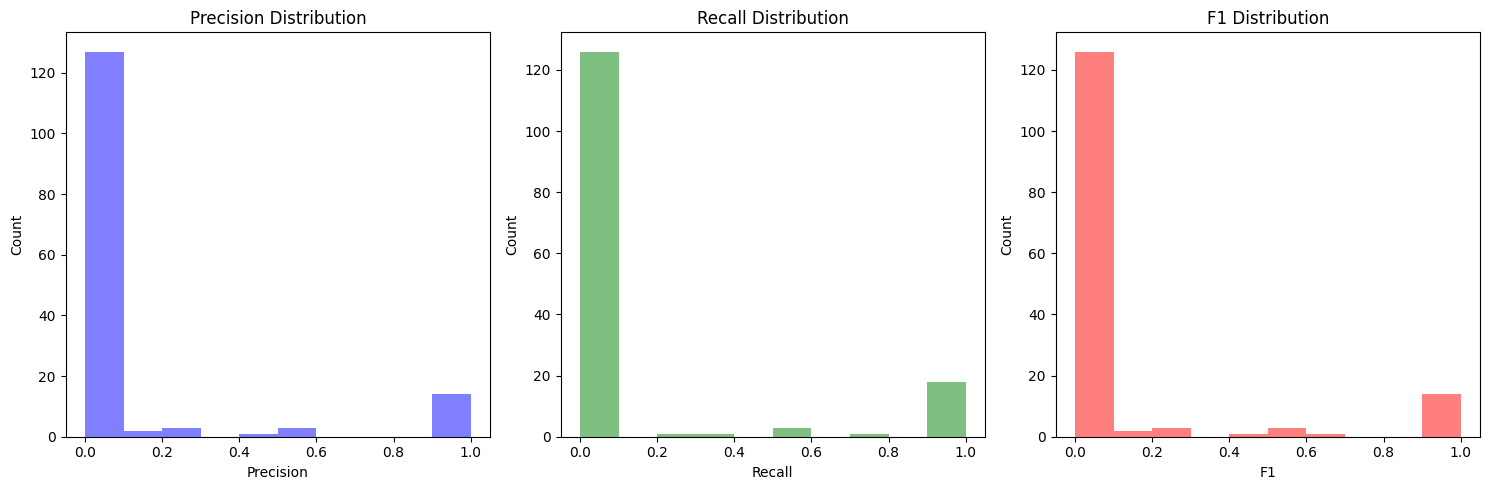

In [ ]:
# gráficos
import matplotlib.pyplot as plt

# Distribuição das métricas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(df_metricas['precision'], bins=10, alpha=0.5, color='blue')
axes[0].set_title('Precision Distribution')
axes[0].set_xlabel('Precision')
axes[0].set_ylabel('Count')

axes[1].hist(df_metricas['recall'], bins=10, alpha=0.5, color='green')
axes[1].set_title('Recall Distribution')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Count')

axes[2].hist(df_metricas['f1'], bins=10, alpha=0.5, color='red')
axes[2].set_title('F1 Distribution')
axes[2].set_xlabel('F1')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

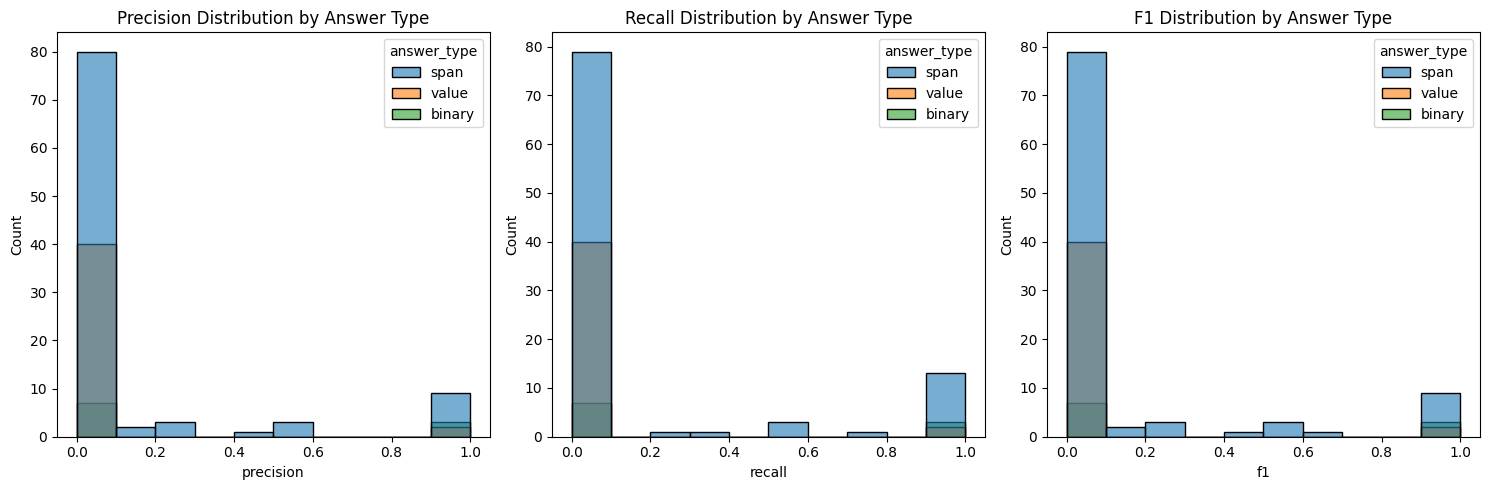

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribuição das métricas segmentadas por tipo de resposta
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Usar seaborn para histogramas com hue
sns.histplot(data=df_metricas, x='precision', hue='answer_type', bins=10, alpha=0.6, ax=axes[0])
axes[0].set_title('Precision Distribution by Answer Type')

sns.histplot(data=df_metricas, x='recall', hue='answer_type', bins=10, alpha=0.6, ax=axes[1])
axes[1].set_title('Recall Distribution by Answer Type')

sns.histplot(data=df_metricas, x='f1', hue='answer_type', bins=10, alpha=0.6, ax=axes[2])
axes[2].set_title('F1 Distribution by Answer Type')

plt.tight_layout()
plt.show()

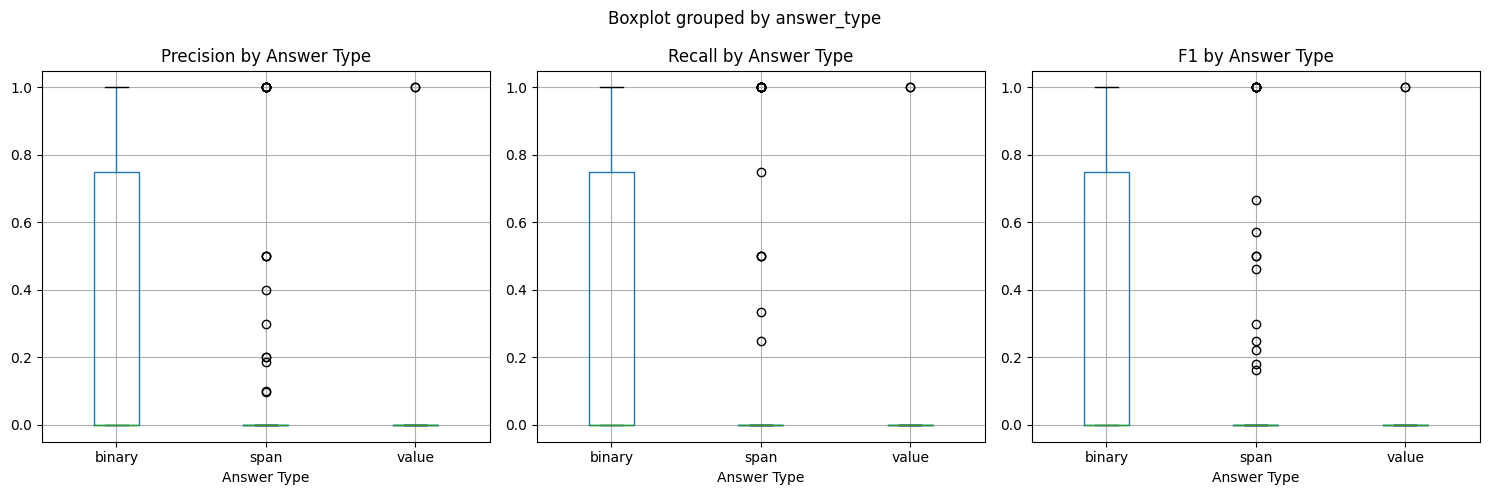

In [ ]:
import matplotlib.pyplot as plt

# Boxplots são melhores para comparar distribuições por categoria
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision
df_metricas.boxplot(column='precision', by='answer_type', ax=axes[0])
axes[0].set_title('Precision by Answer Type')
axes[0].set_xlabel('Answer Type')

# Recall
df_metricas.boxplot(column='recall', by='answer_type', ax=axes[1])
axes[1].set_title('Recall by Answer Type')
axes[1].set_xlabel('Answer Type')

# F1
df_metricas.boxplot(column='f1', by='answer_type', ax=axes[2])
axes[2].set_title('F1 by Answer Type')
axes[2].set_xlabel('Answer Type')

plt.tight_layout()
plt.show()